In [361]:
import pandas as pd
from mvdata import TickerData
import yfinance as yf

def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()
    actions.columns = ["Date", ticker + "Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    decision = []
    previous_decision = ""
    
    for value in actions[ticker + "Signal"].values.tolist():
        if value == previous_decision:
            decision.append("Hold")
        else:
            decision.append(value)
            previous_decision = value
    
    actions[ticker + "Signal"] = decision
    actions = actions.drop(["Date"],axis=1)

    return actions

df = TickerData("AAPL MSFT TSLA").get_historical_data(start_date="2020-01-01")
window = 50

rolling_mean = df.rolling(window=window).mean()
rolling_std = df.rolling(window=window).std()

buy_signal = df < rolling_mean - (2 * rolling_std)
sell_signal = df >= rolling_mean + (2 * rolling_std)

ticker_action = pd.DataFrame(df.index)

for tick in df.columns.tolist():
    ticker_action[tick + "Signal"] = action_tickers(tick,buy_signal,sell_signal)

date = ticker_action.pop("Date")
ticker_action = ticker_action.set_index(date)

[*********************100%%**********************]  3 of 3 completed


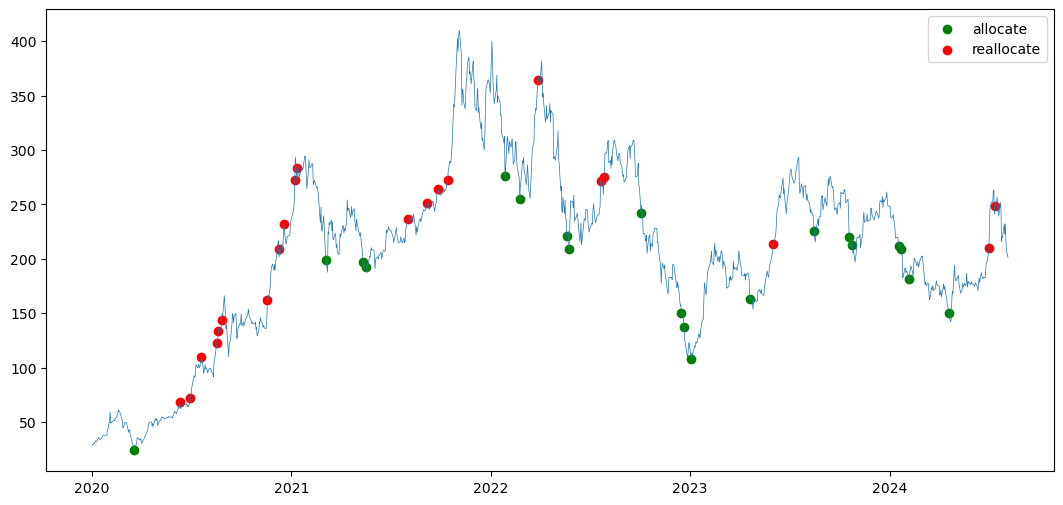

In [371]:
from matplotlib import pyplot as plt

figure, ax = plt.subplots(figsize=(13, 6))

plot_data = pd.concat([df,ticker_action],axis=1)

buy = plot_data.loc[plot_data["TSLASignal"] == "Buy", ["TSLA", "TSLASignal"]]
sell = plot_data.loc[plot_data["TSLASignal"] == "Sell", ["TSLA", "TSLASignal"]]

plt.plot(plot_data["TSLA"],linewidth=.5)

ax.scatter(buy.index,buy["TSLA"],color="green",label="allocate")
ax.scatter(sell.index,sell["TSLA"],color="red",label="reallocate")

plt.legend()
plt.show()

sellTailAction
0% [############################# ] 100% | ETA: 00:00:00

<Axes: title={'center': 'Equity Progression'}>

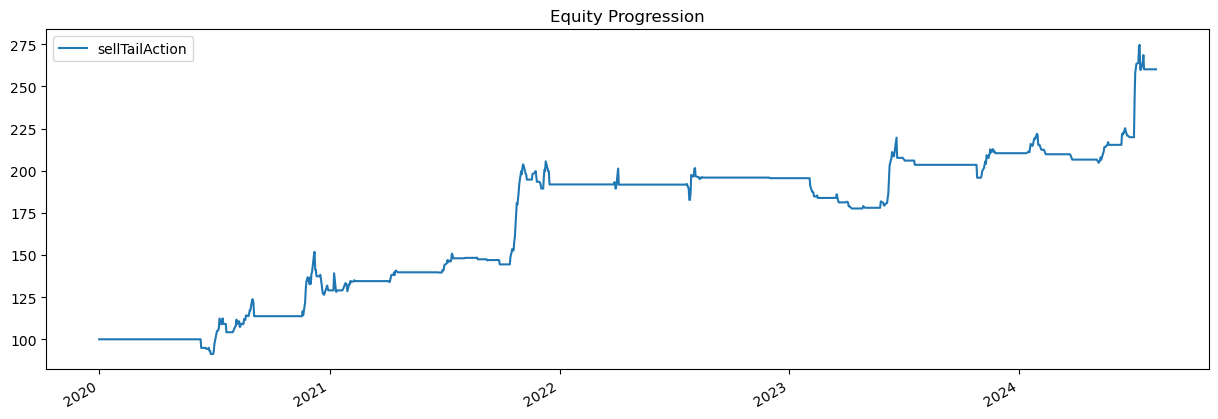

In [366]:
import bt

strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(sell_signal),
                                        bt.algos.RunAfterDays(50),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df,integer_positions=False, progress_bar=True)

res = bt.run(t2)
res.plot()

<Axes: title={'center': 'Equity Progression'}>

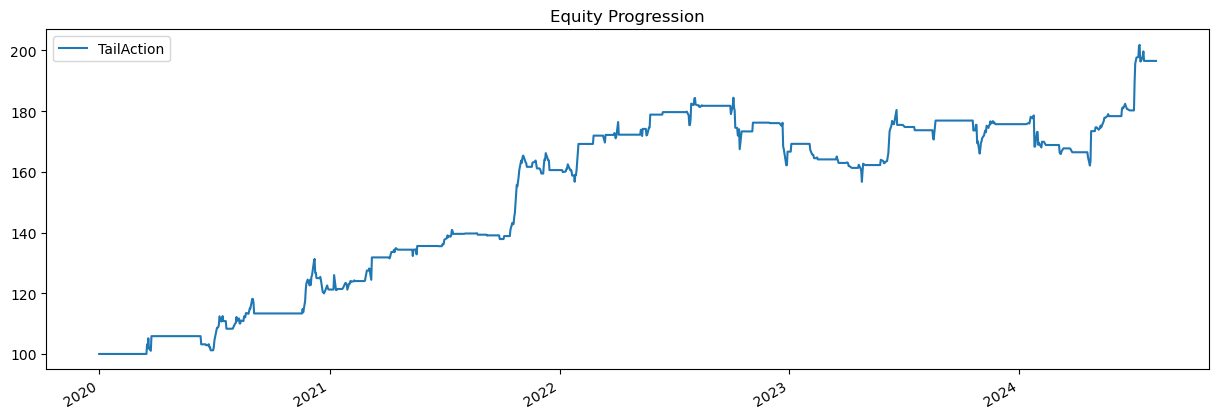

In [362]:
strat1 = bt.Strategy('buyTailAction', [bt.algos.SelectWhere(buy_signal),
                                       bt.algos.RunAfterDays(window),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t1 = bt.Backtest(strat1,df,integer_positions=False, progress_bar=True)

strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(sell_signal),
                                        bt.algos.RunAfterDays(window),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df,integer_positions=False, progress_bar=True)

tests = [t1,t2]

combined_strat = bt.Strategy('TailAction', [bt.algos.SelectAll(),
                                            bt.algos.RunAfterDays(window),
                                            bt.algos.WeighEqually(),
                                            bt.algos.Rebalance()],
                                            children = [x.strategy for x in tests])

combined_test = bt.Backtest(
    combined_strat,
    df,
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

res.plot()

In [364]:
res.display()

Stat                 TailAction
-------------------  ------------
Start                2020-01-01
End                  2024-08-05
Risk-free rate       0.00%

Total Return         96.53%
Daily Sharpe         1.17
Daily Sortino        1.99
CAGR                 15.84%
Max Drawdown         -15.03%
Calmar Ratio         1.05

MTD                  0.00%
3m                   12.53%
6m                   16.98%
YTD                  11.86%
1Y                   13.15%
3Y (ann.)            12.05%
5Y (ann.)            15.84%
10Y (ann.)           -
Since Incep. (ann.)  15.84%

Daily Sharpe         1.17
Daily Sortino        1.99
Daily Mean (ann.)    15.64%
Daily Vol (ann.)     13.41%
Daily Skew           1.22
Daily Kurt           16.80
Best Day             6.33%
Worst Day            -5.78%

Monthly Sharpe       1.14
Monthly Sortino      3.17
Monthly Mean (ann.)  15.72%
Monthly Vol (ann.)   13.75%
Monthly Skew         1.28
Monthly Kurt         3.01
Best Month           16.47%
Worst Month          -5.42

In [2]:
import yfinance as yf
import pandas as pd

# Define the tickers for the comparable companies and the target company
comps_tickers = ['AAPL', 'MSFT', 'GOOGL']  # Example comparable companies
target_ticker = 'GDDY'  # Example target company

# Retrieve financial data for the comparable companies
def get_financial_data(tickers):
    financials = []
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        # Get the necessary financial data
        market_cap = stock.info['marketCap']
        revenue = stock.financials.loc['Total Revenue'][0]
        ebitda = stock.financials.loc['EBITDA'][0]
        financials.append({
            'Ticker': ticker,
            'Market Cap': market_cap,
            'Revenue': revenue,
            'EBITDA': ebitda
        })
    return pd.DataFrame(financials)

# Get financial data for comparable companies
comps_data = get_financial_data(comps_tickers)

# Calculate key financial ratios for comparable companies
comps_data['EV/Revenue'] = comps_data['Market Cap'] / comps_data['Revenue']
comps_data['EV/EBITDA'] = comps_data['Market Cap'] / comps_data['EBITDA']

# Retrieve financial data for the target company
target_data = get_financial_data([target_ticker])

# Display the data
print("Comparable Companies Data:")
print(comps_data)

print("\nTarget Company Data:")
print(target_data)

# Calculate the target company's implied valuation based on comps' multiples
ev_to_revenue_avg = comps_data['EV/Revenue'].mean()
ev_to_ebitda_avg = comps_data['EV/EBITDA'].mean()

target_revenue = target_data['Revenue'].values[0]
target_ebitda = target_data['EBITDA'].values[0]

implied_ev_revenue = target_revenue * ev_to_revenue_avg
implied_ev_ebitda = target_ebitda * ev_to_ebitda_avg

print(f"\nImplied Enterprise Value based on EV/Revenue multiple: ${implied_ev_revenue:,.2f}")
print(f"Implied Enterprise Value based on EV/EBITDA multiple: ${implied_ev_ebitda:,.2f}")


Comparable Companies Data:
  Ticker     Market Cap       Revenue        EBITDA  EV/Revenue  EV/EBITDA
0   AAPL  3572538540032  3.832850e+11  1.291880e+11    9.320841  27.653796
1   MSFT  3465314304000  2.119150e+11  1.051400e+11   16.352379  32.959048
2  GOOGL  2343618215936  3.073940e+11  9.797100e+10    7.624151  23.921550

Target Company Data:
  Ticker   Market Cap       Revenue       EBITDA
0   GDDY  20348987392  4.254100e+09  754100000.0

Implied Enterprise Value based on EV/Revenue multiple: $47,216,781,105.46
Implied Enterprise Value based on EV/EBITDA multiple: $21,249,128,824.76


In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import pairwise_distances_argmin_min

# Define the tickers and industries
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'BABA', 'JPM']
industries = ['Technology', 'Technology', 'Technology', 'Consumer Discretionary', 
              'Communication Services', 'Consumer Discretionary', 'Communication Services', 
              'Technology', 'Consumer Discretionary', 'Financials']

# Retrieve stock price data
def get_stock_price(tickers):
    prices = []
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        price = stock.history(period="1d")['Close'][0]
        prices.append(price)
    return prices

# Get stock prices
prices = get_stock_price(tickers)

# Create a DataFrame
data = pd.DataFrame({
    'Ticker': tickers,
    'Industry': industries,
    'Price': prices
})

# Preprocess the data
encoder = OneHotEncoder()
industry_encoded = encoder.fit_transform(data[['Industry']]).toarray()
price_scaled = StandardScaler().fit_transform(data[['Price']])

# Combine the encoded industry and scaled price
features = pd.DataFrame(industry_encoded).join(pd.DataFrame(price_scaled))

# Perform K-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
data['Cluster'] = kmeans.fit_predict(features)

# Function to find the closest tickers
def find_closest_tickers(ticker, data, features, k=5):
    ticker_index = data[data['Ticker'] == ticker].index[0]
    cluster = data.loc[ticker_index, 'Cluster']
    cluster_data = data[data['Cluster'] == cluster]
    cluster_features = features.iloc[cluster_data.index]
    
    closest_indices, _ = pairwise_distances_argmin_min([features.iloc[ticker_index]], cluster_features)
    
    # Exclude the input ticker and get the closest k tickers
    closest_tickers = cluster_data.iloc[closest_indices].loc[cluster_data.index != ticker_index]['Ticker'].head(k).values
    return closest_tickers

# Example usage
target_ticker = 'AAPL'
closest_tickers = find_closest_tickers(target_ticker, data, features)
print(f"The five closest tickers to {target_ticker} are: {closest_tickers}")


In [ ]:
def find_closest_tickers(ticker, data, k=5):
    ticker_index = data[data['Ticker'] == ticker].index[0]
    cluster = data.loc[ticker_index, 'Cluster']
    cluster_data = data[data['Cluster'] == cluster]
    cluster_features = features.loc[cluster_data.index]

    closest_indices, _ = pairwise_distances_argmin_min([features.loc[ticker_index]], cluster_features)
    closest_tickers = cluster_data.iloc[closest_indices[1:k+1]]['Ticker'].values
    return cluster_features

find_closest_tickers("AAPL", data)

In [25]:
# import json
# import requests
# import os
# import yfinance as yf

# criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

# tickers = list(criteria["Portfolio Weights"].keys())

# for stock_ex in criteria["Exchanges"]:
#     github_branch = "https://raw.githubusercontent.com/rreichel3/US-Stock-Symbols/main"
#     exchange =  "/" + stock_ex + "/" + stock_ex + "_full_tickers.json" 

#     url = github_branch + exchange # combining the repository dataset with the specific exchange

#     resp = requests.get(url)
#     data = json.loads(resp.text)

#     for i in range(len(data)):
#         ticker = data[i]

#         immediate_criteria = list(criteria["Immediate Criteria"].keys()) # ["lastsale", "volume", "marketCap"]
        
#         # important to note that since the list of tickers is massive, need to find any method to narrow scope

#         # Step 1: Check to see if anything is blank from the full json file or ticker already in portfolio
#         if ticker["symbol"] in tickers or any(ticker[checker] == "" for checker in immediate_criteria): 
#             continue

#         # numeric comparison
#         lastsale = float(ticker[immediate_criteria[0]][1:])
#         volume = float(ticker[immediate_criteria[1]])
#         marketCap = float(ticker[immediate_criteria[2]])

#         # Step 2: eliminate low cost stocks, less volume, and bound the marketcap due to portfolio size
#         check_1 = lastsale > criteria["Immediate Criteria"][immediate_criteria[0]] \
#             and volume > criteria["Immediate Criteria"][immediate_criteria[1]]
            
#         check_2 = marketCap <= criteria["Immediate Criteria"][immediate_criteria[2]]

#         if check_1 and check_2:
#             greater = criteria["Portfolio Criteria"]["Greater"]
#             less_than = criteria["Portfolio Criteria"]["Less Than"]

#             symbol = ticker["symbol"]

#             # list of metrics for criteria
#             metrics = list(greater.keys())
#             metrics.extend(list(less_than.keys()))

#             values = dict(filter(lambda item: item[0] in metrics, yf.Ticker(symbol).info.items()))
            
#             try:
#                 # Step 3: select tickers whick satisfy all of these conditions
#                 check_3 = all(values[metric] > x for metric,x in greater.items()) 
#                 check_4 = all(values[metric] < x for metric,x in less_than.items())
#                 if check_3 and check_4:
#                     tickers.append(symbol)

#             except KeyError:
#                 continue

# print(tickers)




    # def shortlist_tickers(self):
    #     tickers = RecommendTicker().get_all_tickers()
    #     new_tickers = []

    #     crit = list(Criteria().get_immediate_criteria().keys())

    #     for stock_ex in self.exchanges:
    #         data = tickers[stock_ex]

    #         ticker_data = []
    #         metric_data = {metric: [] for metric in crit}

    #         for tick_val in data:
    #             check_1 = tick_val["symbol"] in list(Basket().get_portfolio().keys())
    #             check_2 = any(tick_val[checker] == "" for checker in crit)

    #             if check_1 or check_2:
    #                 continue
                
    #             lastsale = float(tick_val[crit[0]][1:])
    #             volume = float(tick_val[crit[1]])
    #             marketCap = float(tick_val[crit[2]])

    #             ticker_data.append(tick_val["symbol"])
                
    #             # loop unrolling to save time here
    #             metric_data[crit[0]].append(lastsale)
    #             metric_data[crit[1]].append(volume)
    #             metric_data[crit[2]].append(marketCap)
                        
    #         metric_arrays = {metric: np.array(values) for metric, values in metric_data.items()}
            
    #         check_3 = np.ones(len(ticker_data), dtype=bool)
    #         check_4 = np.ones(len(ticker_data), dtype=bool)

    #         check_3 &= metric_arrays[crit[0]] > criteria["Immediate Criteria"][crit[0]]
    #         check_3 &= metric_arrays[crit[1]] > criteria["Immediate Criteria"][crit[1]]

    #         check_4 &= metric_arrays[crit[2]] < criteria["Immediate Criteria"][crit[2]]

    #         final_check = check_3 & check_4

    #         ticker_data = np.array(ticker_data)[final_check].tolist()

    #         new_tickers.extend(ticker_data)
        
    #     new_tickers = [tick.replace("/",".") for tick in new_tickers if "^" not in tick]

    #     return new_tickers



# criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

# class Criteria:
#     def __init__(self):
#         self.greater = criteria["Portfolio Criteria"]["Greater"]
#         self.less_than = criteria["Portfolio Criteria"]["Less Than"]
    
#     def get_immediate_criteria(self):
#         return criteria["Immediate Criteria"]
    
#     def get_greater_criteria(self):
#         return self.greater

#     def get_less_criteria(self):
#         return self.less_than
    
#     def get_metrics(self):
#         metrics = list(self.greater.keys())
#         metrics.extend(list(self.less_than.keys()))
#         return metrics

# yoy_dataset = pd.DataFrame()

        # if "yoy_value" in list(sub_data.columns):
        #     sub_data["yoy_value"] = sub_data["yoy_value"].str.replace("[,%)]","",regex=True)
        #     sub_data["yoy_value"] = sub_data["yoy_value"].str.replace("(","-")
            
        #     date1 = sub_data["date"].drop_duplicates().tolist()[0]

        #     sub_data.loc[sub_data["date"] == date1, "yoy_value"] = 0
        #     sub_data["yoy_value"] = sub_data["yoy_value"].replace("-", np.nan)

        #     sub_data["yoy_value"] = sub_data["yoy_value"].astype(float)/100

        #     yoy_dataset = pd.concat([yoy_dataset,sub_data[["account","date","yoy_value"]]])

# yoy_values = pd.DataFrame(index=yoy_dataset["account"].drop_duplicates().tolist(),
#                           columns=yoy_dataset["date"].drop_duplicates().tolist())

    # yoy_values[date] = yoy_dataset.loc[values_dataset["date"] == date, "yoy_value"].values
    # yoy_values[date] = yoy_values[date].fillna(0) 

# yoy_dataset = yoy_dataset.reset_index(drop=True)


In [373]:
from mvsetup import RecommendTicker

RecommendTicker().get_tickers()

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABR%5ED?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABR%5ED&crumb=ispfOFbPmOq
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABR%5EE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABR%5EE&crumb=ispfOFbPmOq
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABR%5EF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABR%5EF&crumb=ispfOFbPmOq
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ACR%5EC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&co

,symbol,name,lastsale,ipoyear,sector,quoteType,beta,profitMargins,priceToBook,trailingEps,forwardEps,quickRatio,currentRatio,debtToEquity,returnOnEquity,enterpriseToRevenue,revenueGrowth
0,A,Agilent Technologies Inc. Common Stock,134.70,1999,Industrials,EQUITY,1.049,0.18844,6.480690,4.220,5.71,1.491,2.147,43.869,0.20709,6.123,-0.084
1,AA,Alcoa Corporation Common Stock,28.44,2016,Industrials,EQUITY,2.456,-0.05139,1.939972,-3.070,2.56,0.780,1.549,47.618,-0.11723,0.939,0.083
2,AACG,ATA Creativity Global American Depositary Shares,0.65,2008,Real Estate,EQUITY,0.857,-0.14887,0.214659,-0.150,-0.99,0.171,0.228,36.423,-0.30508,0.080,0.137
7,AADI,Aadi Bioscience Inc. Common Stock,1.38,,Health Care,EQUITY,0.310,-2.88721,0.374593,-2.550,-2.86,4.690,5.161,1.286,-0.58221,-2.233,-0.088
14,AAOI,Applied Optoelectronics Inc. Common Stock,6.97,2013,Technology,EQUITY,1.966,-0.30652,1.472101,-1.790,0.73,0.883,1.791,59.531,-0.34165,1.848,-0.233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7115,ZVIA,Zevia PBC Class A Common Stock,0.85,2021,Consumer Staples,EQUITY,0.637,-0.15580,0.658943,-1.321,-0.26,1.539,2.784,3.225,-0.47489,-0.010,-0.104
7116,ZVRA,Zevra Therapeutics Inc. Common Stock,7.88,,Health Care,EQUITY,1.972,-1.78470,6.792453,-1.320,-0.61,2.040,2.103,90.717,-0.82271,11.598,0.078
7118,ZWS,Zurn Elkay Water Solutions Corporation Common ...,29.70,2012,Industrials,EQUITY,0.974,0.08799,3.274493,0.730,1.32,1.582,2.835,34.195,0.08043,3.543,0.022
7119,ZYME,Zymeworks Inc. Common Stock,10.00,,Health Care,EQUITY,1.142,-1.79424,1.815486,-1.500,-1.13,6.620,7.009,4.946,-0.26315,6.386,1.748
